In [210]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import os

In [211]:
r = np.array([      # three variables: 2 objectives, 1 constraints
    [1.0, -0.32, 0.15], # Rebounds
    [-0.32, 1.0, 0.26], # Assists
    [0.15, 0.26, 1.0],  # Salary
])
    # Rebounds, Assists, Salary

n = 100_000
shape, scale = [5.5408, 2.9772, 1.1701], [1.1467, 1.1295, 5157057.6371]

In [212]:
def make_pos_def(corr):
    eigvals, eigvecs = np.linalg.eigh(corr)
    eigvals[eigvals < 1e-8] = 1e-8  
    corr_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # normalize diagonal to 1
    d = np.sqrt(np.diag(corr_pd))
    corr_pd = corr_pd / d[:, None] / d[None, :]
    return corr_pd
r_psd = make_pos_def(r)

In [213]:
r_psd

array([[ 1.  , -0.32,  0.15],
       [-0.32,  1.  ,  0.26],
       [ 0.15,  0.26,  1.  ]])

In [214]:
mean = np.zeros(np.shape(r_psd)[0])
z = np.random.multivariate_normal(mean, r_psd, size=n)
u = stats.norm.cdf(z)

In [215]:
samples = np.zeros_like(u)
for i in range(u.shape[1]):
    samples[:, i] = stats.gamma.ppf(u[:, i], a=shape[i], scale=scale[i])

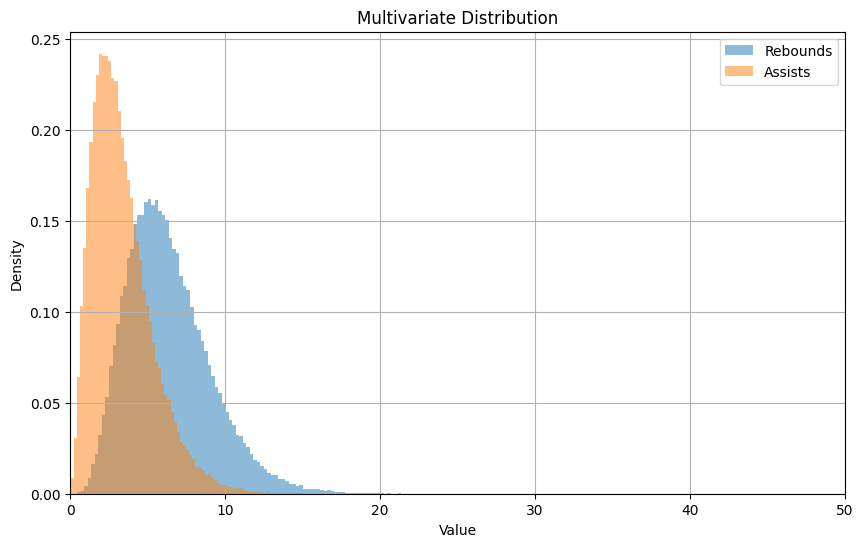

In [216]:
n_dims = samples.shape[1]
names = ["Rebounds", "Assists", "Salary"]

plt.figure(figsize=(10, 6))
for i in range(n_dims - 1):
    plt.hist(samples[:, i], bins=100, density=True, alpha=0.5, label=names[i])

# Plot salary
plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 50)
plt.legend()
plt.grid(True)
plt.show()

In [217]:
expected_values = [a * b for a, b in zip(shape, scale)]

In [218]:
# generate data
def generate_knapsack_data(samples, shape, scale,         
                           n_items=10, max_trials=1000, exp_n_selected=5, trial_needed=100):

    # create column names (list)
    columns = (
        ['trial_number'] +
        [f'objective1_item_{i+1}' for i in range(n_items)] +
        [f'objective2_item_{i+1}' for i in range(n_items)] +
        [f'objective3_item_{i+1}' for i in range(n_items)] 
    )

    # create df with 0's
    df = pd.DataFrame(None, index=range(max_trials), columns=columns)

    valid_trials = 0
    trial_i = 0
    cursor = 0
    
    while True:
        if valid_trials >= trial_needed:
            print(f"Done: built {valid_trials} trials (needed {trial_needed}).")
            break

        if trial_i >= max_trials:
            print(f"ERROR: exceeded max_trials ({max_trials}). Built {valid_trials} trials.")
            break

        if cursor >= samples.shape[0]:
            print(f"ERROR: ran out of samples at cursor={cursor} (N={samples.shape[0]}). "
                f"Built {valid_trials} trials; attempted {trial_i} trials.")
            break
    
        # obtain unique objective and constraint values for the trial
        values = np.empty((n_items, 3), dtype=int)
        seen_obj = set()
        seen_con = set()
        item = 0
        while item < n_items:
            if cursor >= samples.shape[0]:
                print(f"ERROR: ran out of samples while filling trial {trial_i+1} "
                    f"(filled {item}/{n_items}).")
                break
            
            row = samples[cursor, :]
            cursor += 1
            obj = tuple(row[:3])

            if obj in seen_obj:
                continue

            seen_obj.add(obj)
            values[item, :]  = obj
            item += 1

        # obtain capacities for the trial
        # expected number of items selected: exp_n_selected
        cp1 = stats.gamma.rvs(a=shape[2], scale=scale[2], size=1)[0] # can sample out of the loop
        #cp2 = stats.gamma.rvs(a=shape[4], scale=scale[4], size=1)[0]
        capacity1 = cp1 * exp_n_selected
        #capacity2 = np.floor(cp2 * exp_n_selected).astype(int) 

        # check if capacity is zero
        if capacity1 == 0: #  or capacity2 == 0
            trial_i += 1
            continue

            
        # store data into df
        df.loc[valid_trials, 'trial_number'] = valid_trials + 1
        for i in range(n_items):
            df.loc[valid_trials, f'objective1_item_{i+1}'] = values[i, 0]
            df.loc[valid_trials, f'objective2_item_{i+1}'] = values[i, 1]
            df.loc[valid_trials, f'objective3_item_{i+1}'] = values[i, 2]
    
        valid_trials += 1
        trial_i += 1

    df = df.iloc[:trial_needed].reset_index(drop=True)  


    output_dir = "./data"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f'test_data_n{n_items}_exp{exp_n_selected}_clean.csv')
    '''
    if os.path.exists(output_path):
        print(f"File {output_path} already exists")
    else:
        df.to_csv(output_path, index=False)
        print(f"File {output_path} created successfully")
    '''
    df.to_csv(output_path, index=False)

In [ ]:
generate_knapsack_data(samples, shape, scale,
                       n_items=20, max_trials=100, exp_n_selected=5, trial_needed=1)

Done: built 5 trials (needed 5).


In [220]:
np.corrcoef(samples.T)

array([[ 1.        , -0.30171295,  0.12860512],
       [-0.30171295,  1.        ,  0.23784613],
       [ 0.12860512,  0.23784613,  1.        ]])

In [221]:
n_items = 50
df = pd.read_csv('./data/test_data_n20_exp5_clean.csv')
df.head()

,trial_number,objective1_item_1,objective1_item_2,objective1_item_3,objective1_item_4,objective1_item_5,objective1_item_6,objective1_item_7,objective1_item_8,objective1_item_9,...,objective3_item_11,objective3_item_12,objective3_item_13,objective3_item_14,objective3_item_15,objective3_item_16,objective3_item_17,objective3_item_18,objective3_item_19,objective3_item_20
0,1,7,6,4,4,6,4,10,7,5,...,4569993,1423156,162259,12784286,178732,5089062,6585023,1841295,173620,529900
1,2,6,10,4,11,3,6,7,6,22,...,11517631,16248269,2622479,4060944,2884875,1435909,4106965,2639887,1514131,2138570
2,3,3,3,4,2,5,4,7,2,9,...,2832176,12165287,11183741,675431,9953849,13440005,249656,682903,1270509,1278409
3,4,3,8,3,4,5,2,12,2,8,...,2087990,2059908,5128664,9211135,15934922,3407546,9264421,2414443,5279117,3456303
4,5,8,1,6,5,11,5,8,4,3,...,1224628,2145627,8485419,100426,476659,6818111,19069260,8301564,1877951,7842526


In [222]:
# reshape data for visualization
items_df_visual = pd.DataFrame()

for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'Card number': item,
            'Rebounds': df[f'value1_item_{item}'][trial],
            'Assists': df[f'value2_item_{item}'][trial],
            'Salary': df['capacity1'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

items_df_visual

KeyError: 'value1_item_1'

In [ ]:
items_df_visual.iloc[:, 1:6].corr(method='pearson')

,Science,Culture,Govern,Money,Space
Science,1.000000,0.197768,-0.180727,0.277176,-0.361214
Culture,0.197768,1.000000,0.364998,-0.355965,-0.300608
Govern,-0.180727,0.364998,1.000000,0.250240,-0.327881
Money,0.277176,-0.355965,0.250240,1.000000,0.172180
Space,-0.361214,-0.300608,-0.327881,0.172180,1.000000


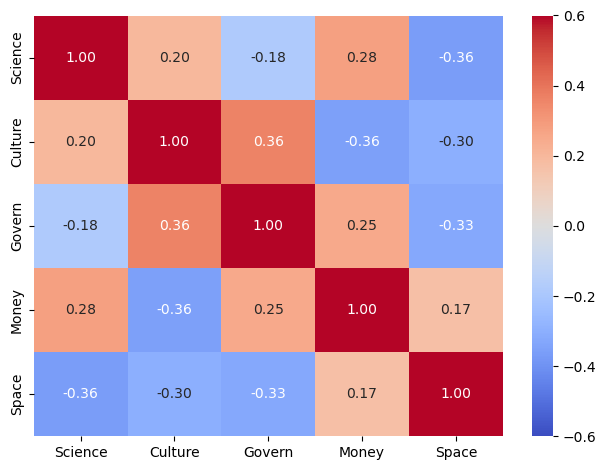

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(items_df_visual.iloc[:, 1:6].corr(method='pearson'),
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  
# plt.savefig("corr_matrix_50cards.png", dpi=300, bbox_inches='tight')
plt.show()

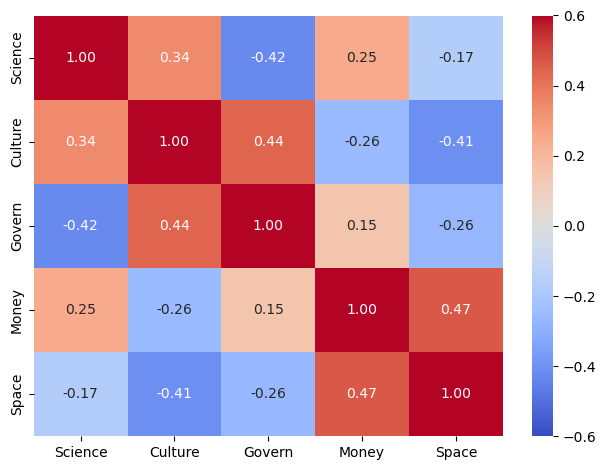

In [ ]:
labels = ["Science", "Culture", "Govern", "Money", "Space"]
sns.heatmap(r_psd, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  # ensures labels aren’t cut off
# plt.savefig("corr_matrix_orginal.png", dpi=300, bbox_inches='tight')
plt.show()